In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
import mne
from mne.io import read_info
import numpy as np
from scipy.optimize import linear_sum_assignment
from hmpai.ica import ICA as hmpICA

In [2]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")
info_path = Path("../data/sat1/preprocessed/processed_0001_epo.fif")
dataset = xr.load_dataset(data_path)

In [23]:
for participant in dataset.participant.values:
    print(participant)

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025


In [3]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(dataset, 60, norm_dummy)
%load_ext line_profiler

In [15]:
%lprun -f ICA.reorder_dataset SAT1Dataset(train_data, shape_topological=shape_topological, info_path=info_path)

Creating RawArray with float64 data, n_channels=30, n_times=214461
    Range : 0 ... 214460 =      0.000 ...  2144.600 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 6.2s.
Reordering dataset


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [4]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(dataset, 60, norm_dummy)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

In [5]:
train_dataset.data.shape

torch.Size([12027, 161, 30])

In [6]:
# info = mne.create_info(
#     ch_names=dataset.channels.values.tolist(),
#     sfreq=100,
#     ch_types="eeg",
# )
mne_info = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

In [16]:
n_comp = 30
ica = ICA(n_components=n_comp, random_state=42, method="fastica")
ica2 = ICA(n_components=n_comp, random_state=42, method="fastica")

In [17]:
train_data = train_dataset.data.squeeze()
train_data_epoch = train_data[0, :]
train_data_epoch[train_data_epoch == 999] = np.nan
raw_train = mne.io.RawArray(train_data_epoch.T, mne_info)

Creating RawArray with float64 data, n_channels=30, n_times=161
    Range : 0 ... 160 =      0.000 ...     1.600 secs
Ready.


In [18]:
val_data = val_dataset.data.squeeze()
input_mask = val_data != 999
val_data = val_data[input_mask].reshape(-1, val_data.shape[2])

test_data = test_dataset.data.squeeze()
input_mask = test_data != 999
test_data = test_data[input_mask].reshape(-1, test_data.shape[2])

In [19]:
raw = mne.io.RawArray(val_data.T, mne_info)
raw2 = mne.io.RawArray(test_data.T, mne_info)

Creating RawArray with float64 data, n_channels=30, n_times=68793
    Range : 0 ... 68792 =      0.000 ...   687.920 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=64493
    Range : 0 ... 64492 =      0.000 ...   644.920 secs
Ready.


In [20]:
ica.fit(raw)
ica2.fit(raw2)

Fitting ICA to data using 30 channels (please be patient, this may take a while)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.0s.


Method,fastica
Fit,32 iterations on raw data (64493 samples)
ICA components,20
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


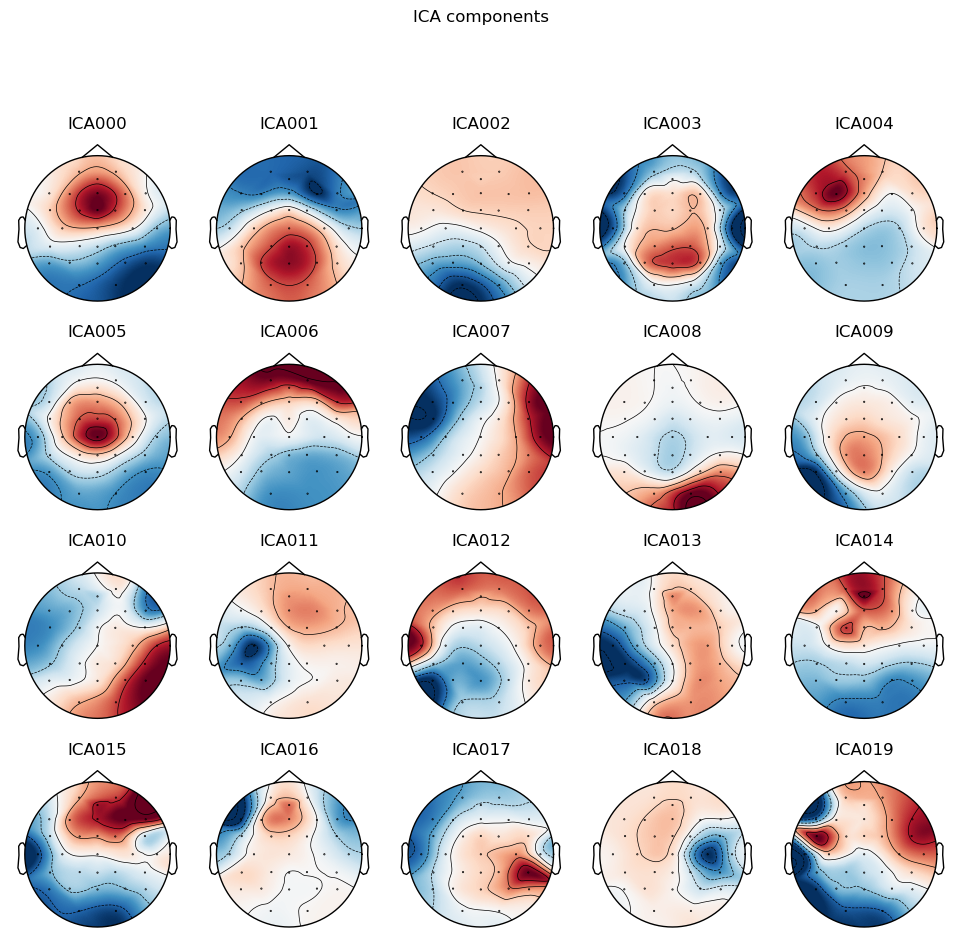

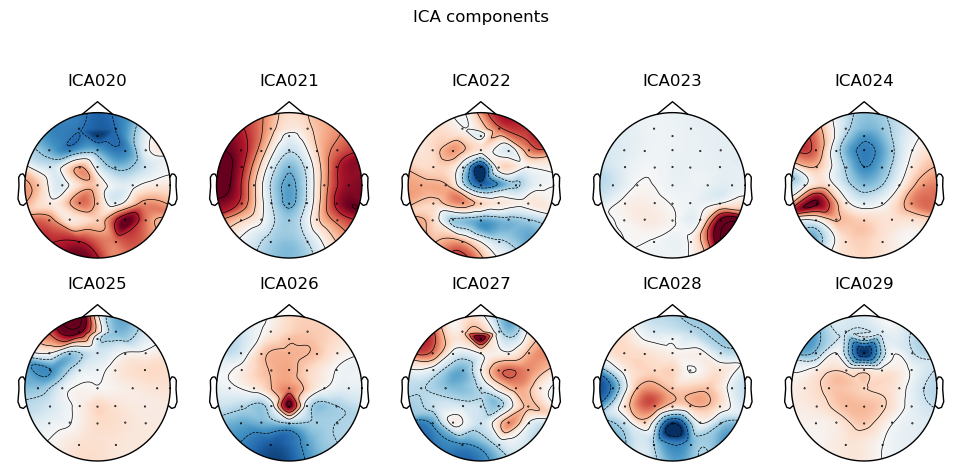

In [18]:
ica.plot_components(inst=raw, show=False)
plt.show()

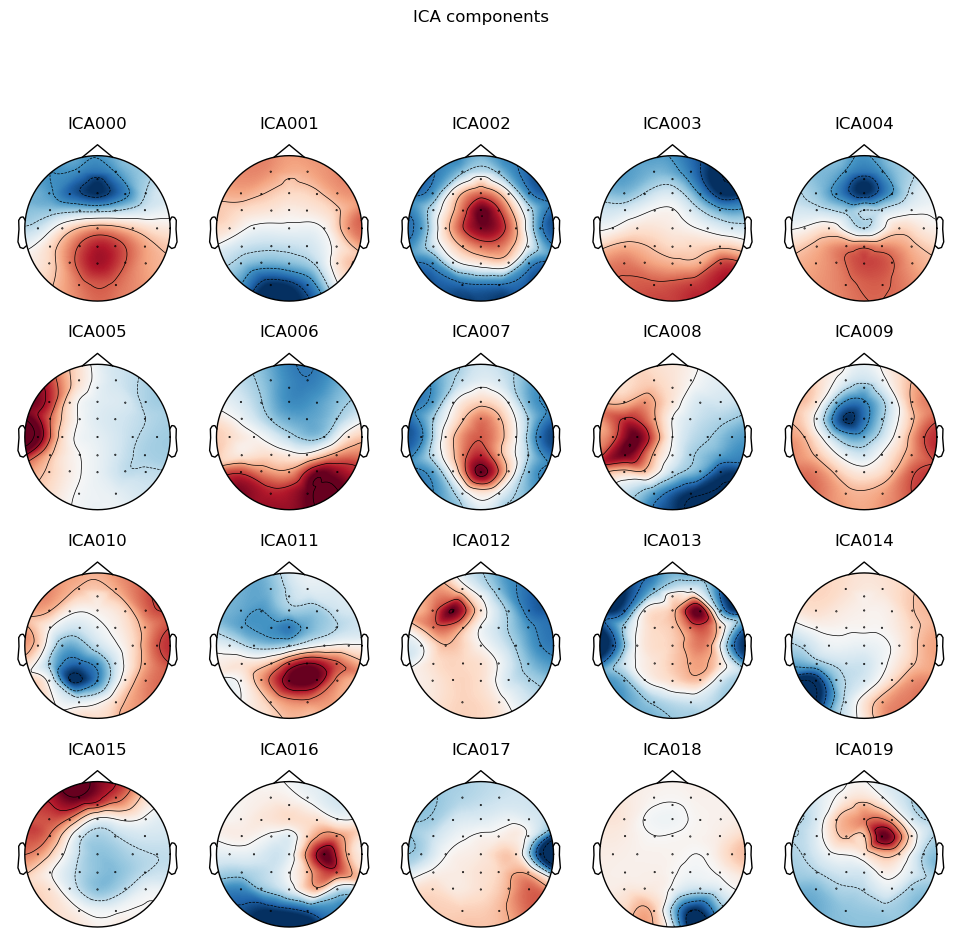

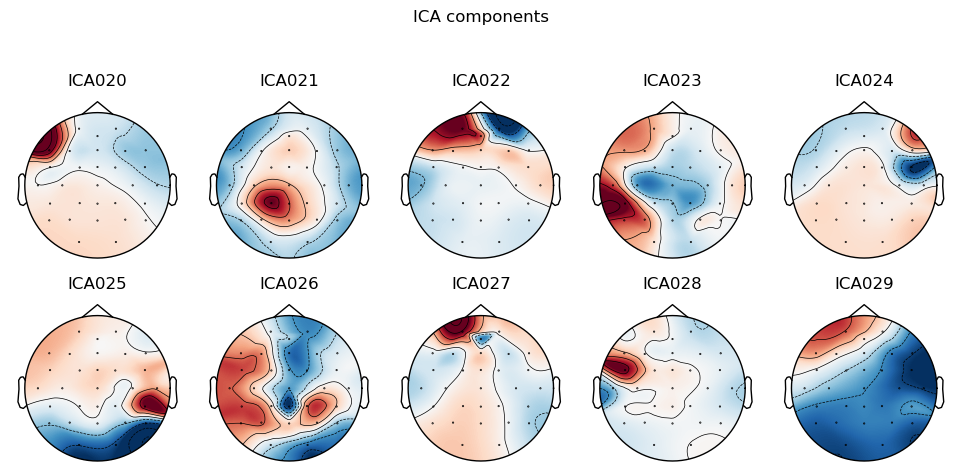

In [19]:
ica2.plot_components(show=False)
plt.show()

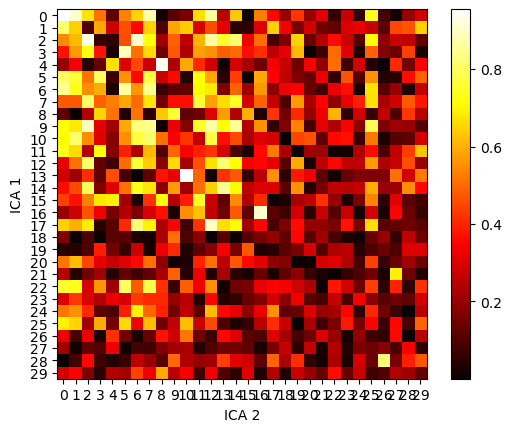

In [12]:
corrs = np.empty((n_comp, n_comp))
for i, comp1 in enumerate(ica.get_components().T):
    for j, comp2 in enumerate(ica2.get_components().T):
        corr = np.corrcoef(comp1, comp2)[0, 1]
        # Use absolute correlation since sign of ICA components is not inherently important
        corrs[i, j] = abs(corr)

plt.imshow(corrs, cmap="hot")
plt.xticks(np.arange(n_comp))
plt.xlabel("ICA 2")
plt.ylabel("ICA 1")
plt.yticks(np.arange(n_comp))
plt.colorbar()
plt.show()

In [39]:
np.array([-2, -1, 0, 1, 2]) ** 2

array([4, 1, 0, 1, 4])

In [13]:
x, y = linear_sum_assignment(-corrs)
# Mean correlation
print("Mean correlation:")
print(np.mean(corrs[x, y]))

for i, j in zip(x, y):
    print(f"ICA 1: {i}, ICA 2: {j}")
    print(corrs[i, j])

Mean correlation:
0.672979766087395
ICA 1: 0, ICA 2: 0
0.954772580463564
ICA 1: 1, ICA 2: 17
0.6477886874378502
ICA 1: 2, ICA 2: 2
0.9274694338318283
ICA 1: 3, ICA 2: 5
0.8842590329573499
ICA 1: 4, ICA 2: 8
0.9422188479574489
ICA 1: 5, ICA 2: 3
0.7994490134728731
ICA 1: 6, ICA 2: 25
0.673786650958501
ICA 1: 7, ICA 2: 11
0.7574069023398217
ICA 1: 8, ICA 2: 9
0.7621747824123745
ICA 1: 9, ICA 2: 14
0.854936026052817
ICA 1: 10, ICA 2: 20
0.46541617601650115
ICA 1: 11, ICA 2: 29
0.6277560183127141
ICA 1: 12, ICA 2: 13
0.8203546786329186
ICA 1: 13, ICA 2: 10
0.9494945095796514
ICA 1: 14, ICA 2: 28
0.5491556116163906
ICA 1: 15, ICA 2: 4
0.6903209124696946
ICA 1: 16, ICA 2: 16
0.9050563524624383
ICA 1: 17, ICA 2: 12
0.9011013894523237
ICA 1: 18, ICA 2: 19
0.35771326512592383
ICA 1: 19, ICA 2: 15
0.47178709107087496
ICA 1: 20, ICA 2: 1
0.6175642273643881
ICA 1: 21, ICA 2: 27
0.6915858069275288
ICA 1: 22, ICA 2: 7
0.780713777904233
ICA 1: 23, ICA 2: 24
0.3329023684130789
ICA 1: 24, ICA 2: 6
0.69

In [21]:
ica.unmixing_matrix_.shape

(20, 20)

In [35]:
ica.get_components().shape

(30, 20)

In [34]:
ica.pca_components_.shape

(30, 30)

In [29]:
np.nanmean([2, 1, 0, 0])

0.75

In [235]:
ica2.unmixing_matrix_ = ica2.unmixing_matrix_[y, :]
ica2.mixing_matrix_ = ica2.mixing_matrix_[:, y]

In [259]:
raw_train.get_data()[0, :]

array([-10.91368675, -12.06278229, -12.97380066, -12.38902187,
        -7.72397947,  -4.55013227,  -4.75407648,  -5.34442663,
        -5.38524866,  -4.68434191,  -7.15862989, -10.97428989,
        -9.82704544,  -7.48506212,  -8.14932156,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

In [260]:
# Gives data in (n_comp, samples) shape, to train on?
ica.get_sources(raw_train).get_data()

array([[-2.00339081, -2.01061734, -1.97413492, ...,         nan,
                nan,         nan],
       [-0.14829161, -0.36687319,  0.0481052 , ...,         nan,
                nan,         nan],
       [ 0.07824128, -0.0838163 , -0.65354405, ...,         nan,
                nan,         nan],
       ...,
       [-0.06607498, -0.07421474, -0.68873015, ...,         nan,
                nan,         nan],
       [ 0.11380427,  0.09929008,  0.16312858, ...,         nan,
                nan,         nan],
       [ 0.21779342,  0.04056901, -0.05084933, ...,         nan,
                nan,         nan]])

In [261]:
ica2.get_sources(raw_train).get_data()[0, :]

array([1.25103798, 1.34399731, 1.11230875, 0.94255682, 0.77667231,
       0.42747388, 0.70519491, 0.76454671, 0.28856095, 0.29613725,
       0.69347962, 0.84297351, 0.94780357, 1.26591179, 1.10115953,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [247]:
ica2.get_sources(raw_train).get_data()[0, :]

array([-4.26587651e-01, -3.77321706e-01, -7.44285538e-01, -8.59568148e-01,
       -1.25645219e-01,  4.61695779e-01,  2.81479311e-01,  8.15045392e-02,
        3.69205362e-01,  3.75555770e-01,  1.57751417e-01,  1.20626468e-01,
       -4.36684538e-01, -4.60743153e-01,  3.52114347e-01,  5.48459026e-01,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -4.60974483e+02, -4.60974483e+02, -4.60974483e+02,
       -4.60974483e+02, -

In [182]:
raw.get_data()

array([[-1.24252373e-02, -1.00654101e+00, -4.40537500e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [-1.62593436e+00, -1.40558231e+00, -3.63094115e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [-9.84772086e-01, -2.48846579e+00, -4.61652517e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       ...,
       [ 3.31135958e-01,  7.22141087e-01,  1.03373468e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [ 5.07523954e-01,  1.60721445e+00,  3.16707754e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [-6.34036958e-01,  4.94326383e-01,  3.25442219e+00, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02]])

In [176]:
ica2.get_sources(raw2).get_data()

(20, 161)

In [38]:
result = ica.fit_transform(input_data[0, :])

In [39]:
ica.get_params()

{'algorithm': 'parallel',
 'fun': 'logcosh',
 'fun_args': None,
 'max_iter': 200,
 'n_components': 30,
 'random_state': 42,
 'tol': 0.0001,
 'w_init': None,
 'whiten': 'unit-variance',
 'whiten_solver': 'svd'}

In [34]:
result = ica(input_data[0, :])

AttributeError: 'ICA' object has no attribute 'fit_transform'

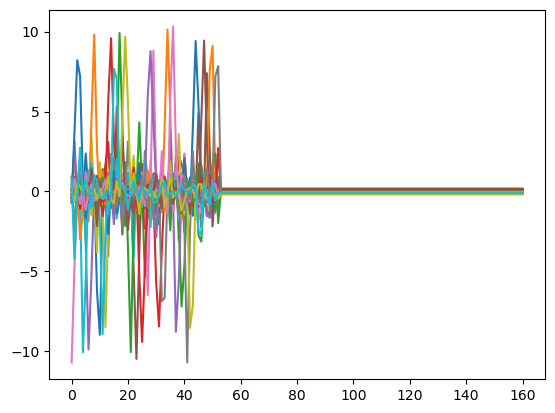